In [1]:
#import library
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [75]:
img_path = "images/zebrafish/bucket_ref.JPG"

img = cv2.imread(img_path)

#convert image color to RGB
img_cvt = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

#plt.figure(figsize=(8,8))
#plt.imshow(img_cvt)

In [76]:
#Resize input image to better fit the screen
#get image width
width_origin = img.shape[1]

#calculate a factor to change width to 1200 px

downsize_perc = 1440 / width_origin
#calculate new height

height_new = int(img.shape[0]*downsize_perc)

#resize image
img_resize = cv2.resize(img, (1440, height_new))

In [77]:
#define variables for mouse call back
drawing = False
refPt = []
img_resize_copy = img_resize.copy()

In [61]:
#define function for drawing rectangle (croping image)
def draw_rect(event, x, y, flags, param):
    global drawing, refPt, img_resize_copy

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        refPt = [(x, y)]

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing == True:
            img_resize_copy = img_resize.copy()
            cv2.rectangle(img_resize_copy, refPt[0], (x, y), (0,0,255), 1)
    
    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        refPt.append((x, y))
        cv2.rectangle(img_resize_copy, refPt[0], (x, y), (0,0,255), 1)


In [62]:
#define function to preprocess image 

def process_image(img, blur=15, thresh_val=150 ):
    
    #convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #blur imgae
    blur = cv2.GaussianBlur(gray, (blur,blur), 0)
    
    #thresholding
    #ret, threshold = cv2.threshold(blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    ret, threshold = cv2.threshold(blur,thresh_val,255,cv2.THRESH_BINARY_INV)
    
    #find contours
    img_contour, contours, hierarchy = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    #filter out unwanted items
    #create empty list to store contour info
    cnt_info = []
    #create empty map to draw fish contour
    fish_contour = np.zeros(threshold.shape)

    for cnt in contours:
    
        #get area of each contour
        area = round(cv2.contourArea(cnt))
    
        #Filter out small non-fish object; Keep object only if its area greater than 1000
        if area > 1000 and 0 not in cnt:   #and True not in np.isin(cnt, [0, threshold.shape[1]-1, threshold.shape[0]-1]):
        
            #Remove fish on image edge; check if cnt coordinates is on 0 or end of axis
            #Filter out objects on left-most or right-most side
            if 0 or threshold.shape[1]-1 not in (cnt[i][0][0] for i in range(len(cnt))):
            
                #Filter out object on top or bottom side
                if 0 or threshold.shape[0]-1 not in (cnt[i][0][1] for i in range(len(cnt))):
       
                    cv2.drawContours(fish_contour, [cnt], 0, 255, -1)
        
                    #get contour centroid
                    M = cv2.moments(cnt)
                    cx = int(M['m10']/M['m00'])
                    cy = int(M['m01']/M['m00'])
                    #get contour perimeter
                    perimeter = round(cv2.arcLength(cnt,True))
                    #save centroid, area, and perimeter in tuple
                    info = (cx, cy, area, perimeter)
                    #append info to info list
                    cnt_info.append(info)
    
    #Extract fish from contours
    fish_contour_int8 = np.uint8(fish_contour)
    rest = cv2.bitwise_and(img, img, mask=fish_contour_int8)

    #change black background to white
    rest[np.where((rest==[0,0,0]).all(axis=2))] = [255,255,255];
    
    #Add fish contour info to image; info[0]=cx; info[1]=cy; info[2]=area; info[3]=perimeter
    font = cv2.FONT_HERSHEY_SIMPLEX
    for info in cnt_info:

        area_string = "area:"+str(info[2])
        cv2.putText(rest, area_string, (info[0],info[1]), font, 1, (0,0,255),2,cv2.LINE_AA)

        peri_string = "peri:"+str(info[3])
        cv2.putText(rest, peri_string, (info[0],info[1]+30), font, 1, (0,0,255),2,cv2.LINE_AA)
    
    
    return rest

In [78]:
#display image
cv2.namedWindow('image')
cv2.setMouseCallback('image',draw_rect)

while(1):
    
    cv2.imshow('image', img_resize_copy)
    
    k = cv2.waitKey(1) & 0xFF
    
    if k == 27: #exit when hit Esc key
        break
    elif k == 13: #crop image when hit enter key
        cv2.destroyWindow('image')
        break

#check if refPt has 2 sets of coordinates
if len(refPt) == 2:
    img_crop = img_resize[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
    img_crop_process = process_image(img_crop)
    cv2.imshow('image', img_crop_process)
    cv2.waitKey(0)
    

cv2.destroyAllWindows()

In [30]:
cnt_area

[1091.5, 4109.0, 6303.5]

In [8]:
# Set up the detector with default parameters.
detector = cv2.SimpleBlobDetector_create()
 
# Detect blobs.
keypoints = detector.detect(img_cvt)
 
# Draw detected blobs as red circles.
# cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
im_with_keypoints = cv2.drawKeypoints(img, keypoints, np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
 

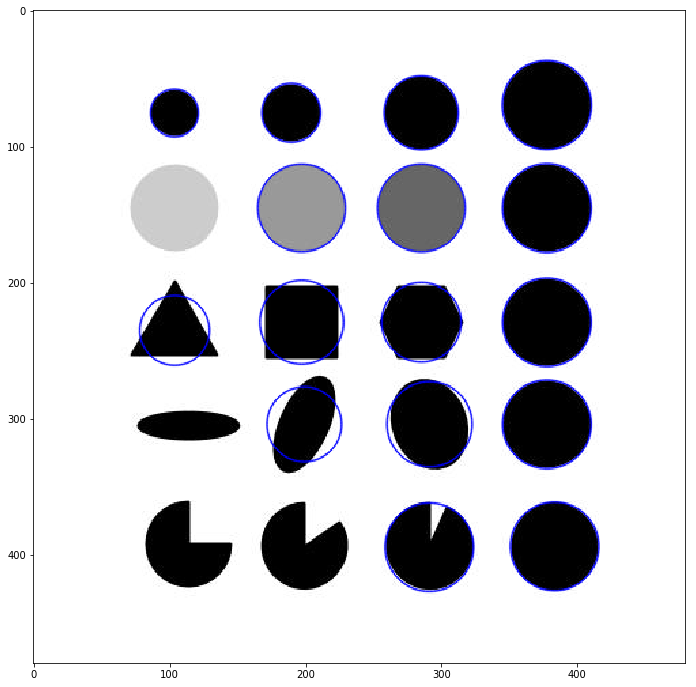

In [9]:
plt.figure(figsize=(12,12))
plt.imshow(im_with_keypoints)